# FINAL CODE

In [8]:
import requests
import fal_client
import os
from PIL import Image
from io import BytesIO

In [9]:
os.environ['FAL_KEY'] = 'abd8d5d0-818f-406e-b212-9f45f6396d41:d3935499c524eedd39be799062757a28'
url = "https://gpt-4o-mini.p.rapidapi.com/chat/completions"


# Helping Functions

In [10]:
def generate_image(vis_prompt, width=500, height=500):
    prompt_for_vis = f"""A vibrant cartoon/comic-style illustration of {vis_prompt}. 
    Bold outlines, exaggerated features, bright colors, and playful proportions. 
    2D, clean and polished, with a fun and expressive atmosphere.
    """
    def on_queue_update(update):
        if isinstance(update, fal_client.InProgress):
            for log in update.logs:
                print(log["message"])
    result_fal = fal_client.subscribe(
            "fal-ai/flux/schnell",
            arguments={
                        "images": [
                                    {
                                    "url": "",
                                    "content_type": "image/jpeg"
                                    }
                                ],
                        "prompt": prompt_for_vis,
                        "num_inference_steps": 4,
                        "num_images": 1,
                        "image_size": {
                              "width": width,
                              "height": height
                            },
                        "acceleration": "high",
                        "enable_safety_checker": False
                        },
            with_logs=True,
            on_queue_update=on_queue_update,
        )

    image_url = result_fal['images'][0]['url']
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    return image

from PIL import Image, ImageDraw, ImageFont

# Your helper function (slightly generalized for re-use)
def make_cartoon_text(text, font_path="ComicNeue-Bold.ttf", font_size=48,
                      fill="yellow", outline="black", outline_width=4, padding=20,
                      bg_color=(0, 0, 0, 0)):
    font = ImageFont.truetype(font_path, font_size)

    # Measure text size
    dummy_img = Image.new("RGB", (1, 1))
    draw_dummy = ImageDraw.Draw(dummy_img)
    bbox = draw_dummy.textbbox((0, 0), text, font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

    # Create image for text bubble
    img_width, img_height = text_width + padding * 2, text_height + padding * 2
    img = Image.new("RGBA", (img_width, img_height), bg_color)
    draw = ImageDraw.Draw(img)

    # Draw outlined text
    def draw_text_with_outline(draw, position, text, font, fill, outline, outline_width):
        x, y = position
        for dx in range(-outline_width, outline_width + 1):
            for dy in range(-outline_width, outline_width + 1):
                if dx != 0 or dy != 0:
                    draw.text((x + dx, y + dy), text, font=font, fill=outline)
        draw.text((x, y), text, font=font, fill=fill)

    draw_text_with_outline(draw, (padding, padding), text, font, fill, outline, outline_width)
    return img


# 1. Create a blank page
def create_page(width=1200, height=1600, color="white"):
    return Image.new("RGBA", (width, height), color)


# 2. Draw a block anywhere on the page
def draw_block(page, xy, fill="lightgray", outline="black", outline_width=3):
    # xy = (x0, y0, x1, y1)
    draw = ImageDraw.Draw(page)
    draw.rectangle(xy, fill=fill, outline=outline, width=outline_width)
    return page


# 3. Place text bubble anywhere
def place_text(page, text, position, font_path="ComicNeue-Bold.ttf", font_size=48,
               fill="yellow", outline="black", outline_width=4, padding=20):
    bubble = make_cartoon_text(
        text, font_path, font_size, fill, outline, outline_width, padding, bg_color=(0, 0, 0, 0)
    )
    page.paste(bubble, position, bubble)  # transparency respected
    return page


# 4. Place an image (dummy or real) anywhere
def place_image(page, img, position, size=None):
    x, y = position
    if size:
        img = img.resize(size)

    w, h = img.size
    rect = (x, y, x + w, y + h)  # bounding box

    page.paste(img, (x, y), img if img.mode == "RGBA" else None)
    return page, rect

from PIL import Image, ImageDraw, ImageFont

def place_wrapped_text(page, text, block_xy, font_path="ComicNeue-Bold.ttf",
                       font_size=20, fill="black", outline="white",
                       outline_width=0, padding=10, align="left", line_spacing=5):
    """
    Places wrapped text inside a block.
    block_xy = (x0, y0, x1, y1) defines the bounding box
    """

    x0, y0, x1, y1 = block_xy
    max_width = x1 - x0 - padding * 2
    max_height = y1 - y0 - padding * 2

    font = ImageFont.truetype(font_path, font_size)
    draw = ImageDraw.Draw(page)

    # Split into lines that fit block width
    words = text.split()
    lines, current_line = [], ""

    for word in words:
        test_line = current_line + " " + word if current_line else word
        bbox = draw.textbbox((0, 0), test_line, font=font)
        line_width = bbox[2] - bbox[0]

        if line_width <= max_width:
            current_line = test_line
        else:
            lines.append(current_line)
            current_line = word

    if current_line:
        lines.append(current_line)

    # Draw text line by line (with outline)
    y = y0 + padding
    for line in lines:
        bbox = draw.textbbox((0, 0), line, font=font)
        line_height = bbox[3] - bbox[1]

        if y + line_height > y1 - padding:  # stop if out of box
            break

        def draw_text_with_outline(draw, position, text, font, fill, outline, outline_width):
            x, y = position
            for dx in range(-outline_width, outline_width + 1):
                for dy in range(-outline_width, outline_width + 1):
                    if dx != 0 or dy != 0:
                        draw.text((x + dx, y + dy), text, font=font, fill=outline)
            draw.text((x, y), text, font=font, fill=fill)

        draw_text_with_outline(draw, (x0 + padding, y), line, font, fill, outline, outline_width)
        y += line_height +  line_spacing

    return page

def estimate_text_box(text, font_path="ComicNeue-Bold.ttf", font_size=20,
                      max_width=None, padding=10, line_spacing=5):
    """
    Given some text and a font, estimate the box size required.
    If max_width is given, wraps text so it doesn't exceed that width.
    Returns: (box_width, box_height, wrapped_lines)
    """

    font = ImageFont.truetype(font_path, font_size)
    dummy_img = Image.new("RGB", (1, 1))
    draw = ImageDraw.Draw(dummy_img)

    # Word wrapping
    words = text.split()
    lines, current_line = [], ""
    for word in words:
        test_line = current_line + " " + word if current_line else word
        bbox = draw.textbbox((0, 0), test_line, font=font)
        line_width = bbox[2] - bbox[0]

        if max_width and line_width > max_width:
            lines.append(current_line)
            current_line = word
        else:
            current_line = test_line

    if current_line:
        lines.append(current_line)

    # Measure the widest line
    max_line_width = 0
    line_height = 0
    for line in lines:
        bbox = draw.textbbox((0, 0), line, font=font)
        line_width = bbox[2] - bbox[0]
        line_height = max(line_height, bbox[3] - bbox[1])
        max_line_width = max(max_line_width, line_width)

    # Final dimensions
    box_width = max_line_width + padding * 2
    box_height = (line_height * len(lines)) + (line_spacing * (len(lines) - 1)) + padding * 2

    return box_width, box_height, lines

def draw_rounded_block(page, xy, radius=20, fill=(255, 255, 200, 255), outline="black", outline_width=2):
    """
    Draws a rounded rectangle block on the page.
    xy = (x0, y0, x1, y1)
    """
    draw = ImageDraw.Draw(page)
    x0, y0, x1, y1 = xy
    draw.rounded_rectangle([x0, y0, x1, y1], radius=radius, fill=fill, outline=outline, width=outline_width)
    return page


import numpy as np

def create_vertical_gradient(width, height, top_color, bottom_color):
    """Create a vertical gradient image"""
    base = np.zeros((height, width, 3), dtype=np.uint8)
    for y in range(height):
        ratio = y / height
        r = int(top_color[0] * (1-ratio) + bottom_color[0] * ratio)
        g = int(top_color[1] * (1-ratio) + bottom_color[1] * ratio)
        b = int(top_color[2] * (1-ratio) + bottom_color[2] * ratio)
        base[y, :] = (r, g, b)
    return Image.fromarray(base, "RGB")

def draw_gradient_rounded_block(page, xy, radius=30, top_color=(255,255,0), bottom_color=(255,128,0), outline="black", outline_width=2):
    x0, y0, x1, y1 = xy
    w, h = x1 - x0, y1 - y0

    # Create gradient image
    gradient = create_vertical_gradient(w, h, top_color, bottom_color)

    # Create mask for rounded rectangle
    mask = Image.new("L", (w, h), 0)
    draw_mask = ImageDraw.Draw(mask)
    draw_mask.rounded_rectangle((0, 0, w, h), radius=radius, fill=255)

    # Paste gradient through mask
    page.paste(gradient, (x0, y0), mask)

    # Draw outline
    draw = ImageDraw.Draw(page)
    draw.rounded_rectangle(xy, radius=radius, outline=outline, width=outline_width)

    return page

def block_and_text(text, page, offset_x, offset_y, max_width):
    box_w, box_h, _ = estimate_text_box(text, font_path="/Users/ijazulhaq/Downloads/strawberry-muffins/Strawberry Muffins Demo.ttf", font_size=20,max_width=max_width, padding=10, line_spacing=5)
    rect = (offset_x, offset_y, offset_x + box_w, offset_y + box_h)
    page = draw_gradient_rounded_block(page, rect,radius=20,top_color=(255,255,200),bottom_color=(255,210,100),outline="black",outline_width=0)
    #occupied.append(rect)
    page = place_wrapped_text(page,text,rect,font_path=f_path,font_size=20,fill="black",outline="white",outline_width=0,line_spacing=5,padding=10)
    #occupied.append(rect)
    return page, rect

def text_and_block(text, page, offset_x, offset_y, max_width):
    box_w, box_h, _ = estimate_text_box(text, font_path="/Users/ijazulhaq/Downloads/strawberry-muffins/Strawberry Muffins Demo.ttf", font_size=20,max_width=max_width, padding=10, line_spacing=5)
    rect = (offset_x, offset_y, offset_x + box_w, offset_y + box_h)
    page = draw_gradient_rounded_block(page, rect,radius=20,top_color=(255,210,100),bottom_color=(255,255,200),outline="black",outline_width=0)
    #occupied.append(rect)
    page = place_wrapped_text(page,text2,rect,font_path=f_path,font_size=20,fill="black",outline="white",outline_width=0,line_spacing=5,padding=10)
    #occupied.append(rect)
    return page, rect


from PIL import ImageDraw, ImageFont

def place_badge(page, rect, text, f_path, radius=40, font_size=24):
    x0, y0, x1, y1 = rect
    cx = (x0 + x1) // 2
    cy = y1

    # badge box (circle bounds)
    badge_rect = (cx - radius, cy - radius, cx + radius, cy + radius)

    # draw the rounded block (circle-like)
    page = draw_gradient_rounded_block(page, badge_rect,radius=radius,top_color=(255,255,50),bottom_color=(255,140,100),outline="black",outline_width=1)

    # measure the text size
    font = ImageFont.truetype(f_path, font_size)
    draw = ImageDraw.Draw(page)
    bbox = draw.textbbox((0,0), text, font=font)
    tw = bbox[2] - bbox[0]
    th = bbox[3] - bbox[1]

    # position text in the center of the circle
    tx = cx - tw // 2
    ty = cy - th // 2

    page = place_text(page, text,(tx, ty),font_path=f_path,font_size=font_size,fill="black",outline="black",outline_width=0,padding=0)

    return page

from PIL import Image

def add_margins(page, top=50, right=50, bottom=50, left=50, color=(255, 255, 255, 255)):
    """
    Adds margins (whitespace) to an existing page.
    """
    width, height = page.size
    new_width = width + left + right
    new_height = height + top + bottom
    
    # create new page with background color
    new_page = Image.new("RGBA", (new_width, new_height), color)
    
    # paste original page into new one (shifted by margins)
    new_page.paste(page, (left, top))
    return new_page

from PIL import ImageDraw

def draw_page_border(page, border_color="black", border_width=5, margin=10):
    draw = ImageDraw.Draw(page)
    w, h = page.size
    # rectangle coords with margin
    x0, y0 = margin, margin
    x1, y1 = w - margin, h - margin
    
    draw.rectangle([x0, y0, x1, y1], outline=border_color, width=border_width)
    return page

from PIL import ImageDraw

def draw_circle(page, center, radius, outline="black", outline_width=3, fill=None):
    draw = ImageDraw.Draw(page)
    x, y = center
    bbox = [x - radius, y - radius, x + radius, y + radius]

    draw.ellipse(bbox, outline=outline, width=outline_width, fill=fill)
    return page




def titleBlock(text, page, offset_x, offset_y, max_width):
    box_w, box_h, _ = estimate_text_box(text, font_path="/Users/ijazulhaq/Downloads/strawberry-muffins/Strawberry Muffins Demo.ttf", font_size=37,max_width=max_width, padding=10, line_spacing=5)
    page_width, _ = page.size
    offset_x = (page_width - box_w) // 2
    rect = (offset_x, offset_y, offset_x + box_w, offset_y + box_h)
    page = draw_gradient_rounded_block(page, rect,radius=15,top_color=(255,255,230),bottom_color=(255,210,100),outline="black",outline_width=1)
    page = place_wrapped_text(page,text,rect,font_path=f_path,font_size=37,fill="black",outline="white",outline_width=0,line_spacing=5,padding=10)
    return page, rect


In [1318]:
prompt='''
You are a story script writer.
The user will give you a short idea: A tiger and a little boy being friends.
Expand it into a short, meaningful story told across exactly 8 panels.
Each panel's text should be about 25 words or more.
No hints about the visual description of the scene. The panels should only have story text format.
Avoid complex words or concepts.
Avoid introducing any extra characters
Visual descriptions should be in simplistic language straight-forward

The story should have a beginning, middle, and end.

The final panel should deliver a lesson, moral, or funny twist.

Structure your response like this:

**Story Title:** <title here>

**Panel 1 Text:** <narration or dialogue>
**Panel 1 Visual Description:** <simplistic and indepenedent visual description>
**Panel 2 Text:** <narration or dialogue>
**Panel 1 Visual Description:** <simplistic and indepenedent visual description>

… continue until Panel 8.
'''


headers = {
    "x-rapidapi-key": "1bf02a2893mshdf19511f9f91ec7p1d360fjsn6c1314c7778b",
    "x-rapidapi-host": "gpt-4o-mini.p.rapidapi.com",
    "Content-Type": "application/json"
}
payload = {"model":"gpt-4o-mini","messages":[{"role":"user","content":prompt}]}
response = requests.post(url, json=payload, headers=headers)

res = response.json()['choices'][0]['message']['content']

In [1319]:
title = res.split('**Panel')[0].replace('**','').strip()
texts = [i.split('**')[1].strip() for i in res.split('**Panel')[1:]][::2]
vis = [i.split('**')[1].strip() for i in res.split('**Panel')[1:]][1::2]

text_context = '. '.join(texts)


In [1320]:
cover_prompt = f"""
You are a creative assistant. 
I have a comic story with 8 panels. 
Each panel has two parts: a narration text and a visual description.

Your task: Based on the narration and visual descriptions together, 
write ONE SINGLE IMAGE PROMPT that would be perfect for generating 
a COMIC BOOK COVER in an AI image model like Schnell. 
The prompt should be not be longer than 30 words

Also classify the story into being one of the four classes: [Adventure, Comedy, Fantasy, Slice of Life]

Guidelines:
- Focus on the main character(s) and the setting.
- Dont mention characters by name mention them generally
- Capture the overall theme, tone, or moral of the story.
- Use bold, cinematic comic-book style language.
- Avoid listing panels. Summarize into one powerful visual idea.
- Include details about colors, mood, perspective, and style.

Here is the story content:
{text_context}

Output format:

**story class:** <class>
**text prompt:** <prompt here>
"""

headers = {
    "x-rapidapi-key": "1bf02a2893mshdf19511f9f91ec7p1d360fjsn6c1314c7778b",
    "x-rapidapi-host": "gpt-4o-mini.p.rapidapi.com",
    "Content-Type": "application/json"
}
payload = {"model":"gpt-4o-mini","messages":[{"role":"user","content":cover_prompt}]}
response = requests.post(url, json=payload, headers=headers)

cover_res = response.json()['choices'][0]['message']['content']
cover_prompt_for_schnell = cover_res.split('**text prompt:**')[-1].strip()
genre = cover_res.split('**text prompt:**')[0].split('**')[-1].strip()

In [1335]:
from tqdm import tqdm
for i in tqdm(range(len(vis))):
    if i in range(2,4):
        img = generate_image(vis[i], width=620, height=300)
        img.save(f'/Users/ijazulhaq/Comicbook/static/output_images/image_{i}.jpg')
    else:
        img = generate_image(vis[i])
        img.save(f'/Users/ijazulhaq/Comicbook/static/output_images/image_{i}.jpg')
        
img = generate_image(cover_prompt_for_schnell, width=700, height=1040)
img.save(f'/Users/ijazulhaq/Comicbook/static/output_images/cover_image.jpg')

print('Images Generated Successfully')


100%|█████████████████████████████████████████████| 8/8 [00:38<00:00,  4.85s/it]


Images Generated Successfully


# Pages formation

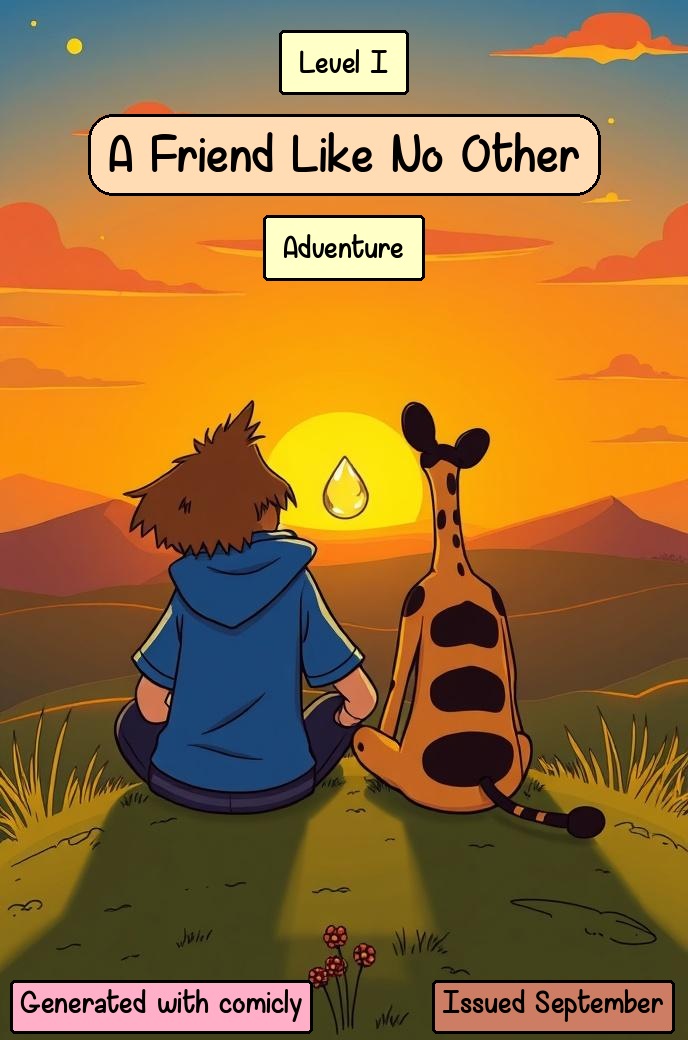

In [1336]:
import textwrap

text = "Level I"
title_text = title.split(": ")[-1]  # your second title

cover = Image.open(f'/Users/ijazulhaq/Comicbook/static/output_images/cover_image.jpg')
draw = ImageDraw.Draw(cover)
font = ImageFont.truetype(f_path, 30)

# ------------------- First text (wrapped, top centered) -------------------
max_width = cover.size[0] - 100  # leave some margin
lines = []
line = ""
for word in text.split():
    test_line = line + (" " if line else "") + word
    bbox = draw.textbbox((0, 0), test_line, font=font)
    if bbox[2] - bbox[0] <= max_width:
        line = test_line
    else:
        lines.append(line)
        line = word
if line:
    lines.append(line)

# total text block height
line_heights = [draw.textbbox((0,0), l, font=font)[3] - draw.textbbox((0,0), l, font=font)[1] for l in lines]
text_h = sum(line_heights) + (len(lines)-1)*10
text_w = max([draw.textbbox((0,0), l, font=font)[2] for l in lines])

page_w, page_h = cover.size
x = (page_w - text_w) // 2
y = 50  # fixed margin from top

# Rounded rectangle behind first text
padding = 20
radius = 5
rect1 = [x - padding, y - padding, x + text_w + padding, y + text_h + padding]
draw.rounded_rectangle(rect1, radius=radius, fill=(255, 255, 200), outline="black", width=3)

# Draw each line centered
line_y = y
for l in lines:
    bbox = draw.textbbox((0, 0), l, font=font)
    lw = bbox[2] - bbox[0]
    draw.text(((page_w - lw)//2, line_y), l, font=font, fill="black")
    line_y += (bbox[3] - bbox[1]) + 10

# ------------------- Second text (below first with gap) -------------------
font = ImageFont.truetype(f_path, 50)

gap = 40  # 👈 adjustable space between first and second blocks
y2 = rect1[3] + gap  # start below the first block

bbox = draw.textbbox((0, 0), title_text, font=font)
text_w2, text_h2 = bbox[2] - bbox[0], bbox[3] - bbox[1]
x2 = (page_w - text_w2) // 2

# Rounded rectangle behind second text
padding = 20
radius = 25
rect2 = [x2 - padding, y2 - padding, x2 + text_w2 + padding, y2 + text_h2 + padding]
draw.rounded_rectangle(rect2, radius=radius, fill=(255, 220, 180), outline="black", width=3)

# Draw second text
draw.text((x2, y2), title_text, font=font, fill="black")


# ------------------- Second text (below first with gap) -------------------
font = ImageFont.truetype(f_path, 30)

gap = 40  # 👈 adjustable space between first and second blocks
y3 = rect2[3] + gap  # start below the first block

bbox = draw.textbbox((0, 0), genre, font=font)
text_w3, text_h3 = bbox[2] - bbox[0], bbox[3] - bbox[1]
x3 = (page_w - text_w3) // 2

# Rounded rectangle behind second text
padding = 20
radius = 5
rect3 = [x3 - padding, y3 - padding, x3 + text_w3 + padding, y3 + text_h3 + padding]
draw.rounded_rectangle(rect3, radius=radius, fill=(255, 255, 200), outline="black", width=3)

# Draw second text
draw.text((x3, y3), genre, font=font, fill="black")




# ------------------- Second text (below first with gap) -------------------
font = ImageFont.truetype(f_path, 30)

gap = 0  # 👈 adjustable space between first and second blocks
y4 = cover.size[1]-(50)  # start below the first block

bbox = draw.textbbox((0, 0), 'Generated with comicly', font=font)
text_w4, text_h4 = bbox[2] - bbox[0], bbox[3] - bbox[1]
x4 = (page_w - text_w4)*0.1 // 2

# Rounded rectangle behind second text
padding = 10
radius = 5
rect4 = [x4 - padding, y4 - padding, x4 + text_w4 + padding, y4 + text_h4 + padding]
draw.rounded_rectangle(rect4, radius=radius, fill=(255, 175, 200), outline="black", width=3)

# Draw second text
draw.text((x4, y4), 'Generated with comicly', font=font, fill="black")


# ------------------- Second text (below first with gap) -------------------
font = ImageFont.truetype(f_path, 30)

gap = 0  # 👈 adjustable space between first and second blocks
y5 = cover.size[1]-(50)  # start below the first block

bbox = draw.textbbox((0, 0), 'Issued September', font=font)
text_w5, text_h5 = bbox[2] - bbox[0], bbox[3] - bbox[1]
x5 = (page_w - text_w5)*1.9 // 2

# Rounded rectangle behind second text
padding = 10
radius = 5
rect5 = [x5 - padding, y5 - padding, x5 + text_w5 + padding, y5 + text_h5 + padding]
draw.rounded_rectangle(rect5, radius=radius, fill=(205, 125, 100), outline="black", width=3)

# Draw second text
draw.text((x5, y5), 'Issued September', font=font, fill="black")


cover.save()


In [18]:
def return_pages():
    occupied = []

    f_path = "/Users/ijazulhaq/Downloads/strawberry-muffins/Strawberry Muffins Demo.ttf"

    text1 = texts[0] 
    text2 = texts[1] 
    text3 = texts[2] 
    text4 = texts[3] 
    text5 = texts[4] 
    text6 = texts[5] 
    text7 = texts[6] 
    text8 = texts[7] 

    page1 = create_page(640, 950, color=(255,255,255, 0))
    page2 = create_page(640, 950, color=(255,255,255, 0))
    page3 = create_page(640, 950, color=(255,255,255, 0))


    # ------------- Page 1------------------------
    # --- LEFT COLUMN: image first, then text ---
    img = Image.open("/Users/ijazulhaq/Comicbook/static/output_images/image_0.jpg")
    page1, rect_img_left = place_image(page1, img, (0, 0), size=(300, 300))
    page1, rect_text_left = block_and_text(text1, page1, 0, rect_img_left[3] + 20, 300)
    page1 = place_badge(page1, rect_img_left, "1", f_path, radius=22, font_size=20)

    # --- RIGHT COLUMN: text first, then image ---
    img = Image.open("/Users/ijazulhaq/Comicbook/static/output_images/image_1.jpg")
    page1, rect_text_right = block_and_text(text2, page1, 320, 0, 300)
    page1, rect_img_right = place_image(page1, img, (320, rect_text_right[3] + 20), size=(300, 300))
    page1 = place_badge(page1, rect_text_right, "2", f_path, radius=22, font_size=20)

    # --- LOWER: image first, then text ---

    img = Image.open("/Users/ijazulhaq/Comicbook/static/output_images/image_2.jpg")
    if rect_img_right[3]> rect_text_left[3]:
        page1, rect_img_low = place_image(page1, img, (0, rect_img_right[3]+ 20), size=(620, 300))
    else:
        page1, rect_img_low = place_image(page1, img, (0, rect_text_left[3]+ 20), size=(620, 300))
    page1, rect_text_low = block_and_text(text3, page1, 0, rect_img_low[3]+20, 600)
    page1 = place_badge(page1, rect_img_low, "3", f_path, radius=22, font_size=20)



    # ------------- Page 2------------------------
    # --- High: image first, then text ---
    img = Image.open("/Users/ijazulhaq/Comicbook/static/output_images/image_3.jpg")
    page2, rect_text_low = block_and_text(text4, page2, 0, 0, 600)
    page2, rect_img_low = place_image(page2, img, (0, rect_text_low[3]+20), size=(620, 300))
    page2 = place_badge(page2, rect_text_low, "4", f_path, radius=22, font_size=20)

    # --- Left COLUMN: text first, then image ---
    img = Image.open("/Users/ijazulhaq/Comicbook/static/output_images/image_4.jpg")
    page2, rect_text_left = block_and_text(text5, page2, 0, rect_img_low[3]+20, 300)
    page2, rect_img_left = place_image(page2, img, (0, rect_text_left[3] + 20), size=(300, 300))
    page2 = place_badge(page2, rect_text_left, "5", f_path, radius=22, font_size=20)

    # --- right COLUMN: image first, then text ---
    img = Image.open("/Users/ijazulhaq/Comicbook/static/output_images/image_5.jpg")
    page2, rect_img_right = place_image(page2, img, (320, rect_img_low[3]+20), size=(300, 300))
    page2, rect_text_right = block_and_text(text6, page2, 320, rect_img_right[3] + 20, 300)
    page2 = place_badge(page2, rect_img_right, "6", f_path, radius=22, font_size=20)


    # ------------- Page 3------------------------
    # --- LEFT COLUMN: image first, then text ---
    img = Image.open("/Users/ijazulhaq/Comicbook/static/output_images/image_6.jpg")
    page3, rect_img_left = place_image(page3, img, (0, 0), size=(300, 300))
    page3, rect_text_left = block_and_text(text7, page3, 0, rect_img_left[3] + 20, 300)
    page3 = place_badge(page3, rect_img_left, "7", f_path, radius=22, font_size=20)

    # --- RIGHT COLUMN: text first, then image ---
    img = Image.open("/Users/ijazulhaq/Comicbook/static/output_images/image_7.jpg")
    page3, rect_text_right = block_and_text(text8, page3, 320, 0, 300)
    page3, rect_img_right = place_image(page3, img, (320, rect_text_right[3] + 20), size=(300, 300))
    page3 = place_badge(page3, rect_text_right, "8", f_path, radius=22, font_size=20)
    
    page1 = page1.convert('RGB')#.save('/Users/ijazulhaq/Comicbook/static/pages/02.jpg')
    page2 = page2.convert('RGB')#.save('/Users/ijazulhaq/Comicbook/static/pages/03.jpg')
    page3 = page3.convert('RGB')#.save('/Users/ijazulhaq/Comicbook/static/pages/04.jpg')

    page1 = add_margins(page1, top=90, right=50, bottom=0, left=10, color=(255, 255, 255, 255))
    page2 = add_margins(page2, top=90, right=10, bottom=0, left=50, color=(255, 255, 255, 255))
    page3 = add_margins(page3, top=90, right=50, bottom=0, left=10, color=(255, 255, 255, 255))

    page1 = draw_page_border(page1, border_color="black", border_width=2, margin=0)
    page2 = draw_page_border(page2, border_color="black", border_width=2, margin=0)
    page3 = draw_page_border(page3, border_color="black", border_width=2, margin=0)

    for i in range(1,12):
        draw_circle(page1, (650+50,200+i*50), 15, outline="black", outline_width=3, fill='black')
        draw_circle(page1, (650+50,200+i*50), 10, outline="white", outline_width=3, fill='white')

        draw_circle(page2, (0,200+i*50), 15, outline="black", outline_width=3, fill='black')
        draw_circle(page2, (0,200+i*50), 10, outline="white", outline_width=3, fill='white')

    
    return page1, page2, page3


In [1345]:
title.split(':')[-1].strip()

'A Friend Like No Other'

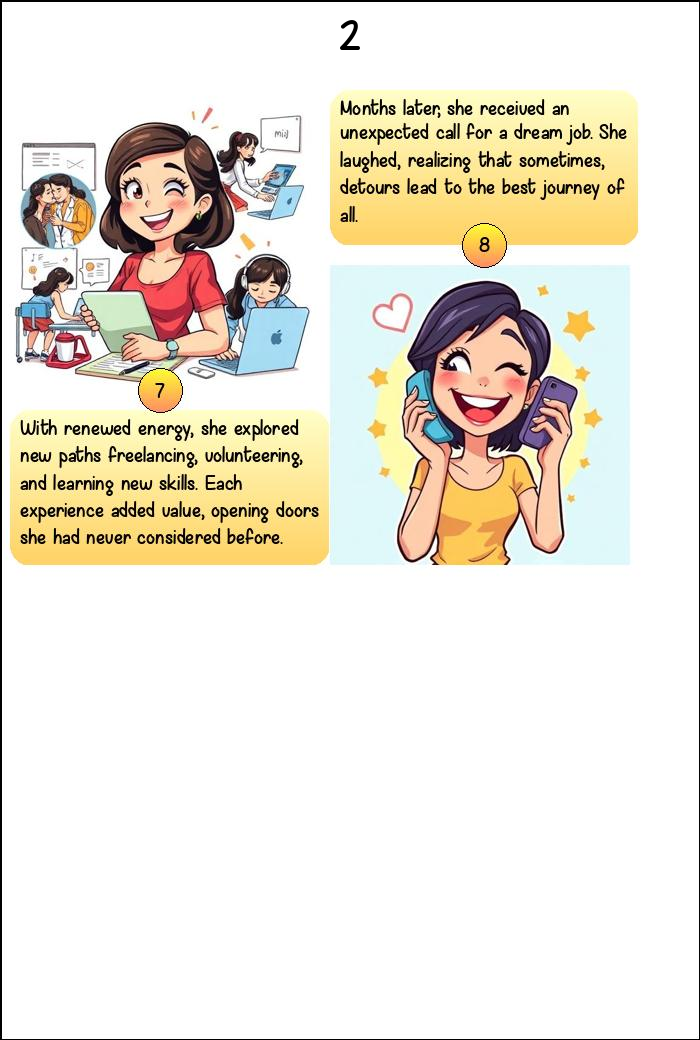

In [28]:

from PIL import ImageDraw, ImageFont


f_path = "/Users/ijazulhaq/Downloads/strawberry-muffins/Strawberry Muffins Demo.ttf"

def titleBlock(title, page, page_num, offset_y, font_path=f_path, font_size=40):
    draw = ImageDraw.Draw(page)
    font = ImageFont.truetype(font_path, font_size)

    page_width, _ = page.size

    # --- Title (centered) ---
    tw, th = draw.textbbox((0, 0), title, font=font)[2:]  # width, height
    tx = (page_width - tw) // 2
    draw.text((tx, offset_y), title, font=font, fill="black")

    # --- Page number (right-aligned) ---
    pw, ph = draw.textbbox((0, 0), page_num, font=font)[2:]
    px = page_width - pw - 20   # 20px margin
    draw.text((px, offset_y), page_num, font=font, fill="black")

    return page

def pagenum(page, page_num, offset_y, font_path=f_path, font_size=40):
    draw = ImageDraw.Draw(page)
    font = ImageFont.truetype(font_path, font_size)

    page_width, _ = page.size

    # --- Title (centered) ---
    tw, th = draw.textbbox((0, 0), page_num, font=font)[2:]  # width, height
    tx = (page_width - tw) // 2
    draw.text((tx, offset_y), page_num, font=font, fill="black")

    return page

page = Image.open('/Users/ijazulhaq/Comicbook/static/pages/04.jpg')

pagenum(page, '2', 20)
#titleBlock(title.split(':')[-1].strip(), page2, '2', 20)
#page = titleBlock(title.split(':')[-1].strip(), page3, '3', 20)


In [29]:
#page = Image.open('/Users/ijazulhaq/Comicbook/static/pages/04.jpg')
page.size

(700, 1040)

In [30]:
page = Image.open('/Users/ijazulhaq/Comicbook/static/pages/04.jpg')
page.size

(700, 1040)

In [1363]:
cover.convert('RGB').save('/Users/ijazulhaq/Comicbook/static/pages/01.jpg')
page1.convert('RGB').save('/Users/ijazulhaq/Comicbook/static/pages/02.jpg')
page2.convert('RGB').save('/Users/ijazulhaq/Comicbook/static/pages/03.jpg')
page3.convert('RGB').save('/Users/ijazulhaq/Comicbook/static/pages/04.jpg')

# Playground

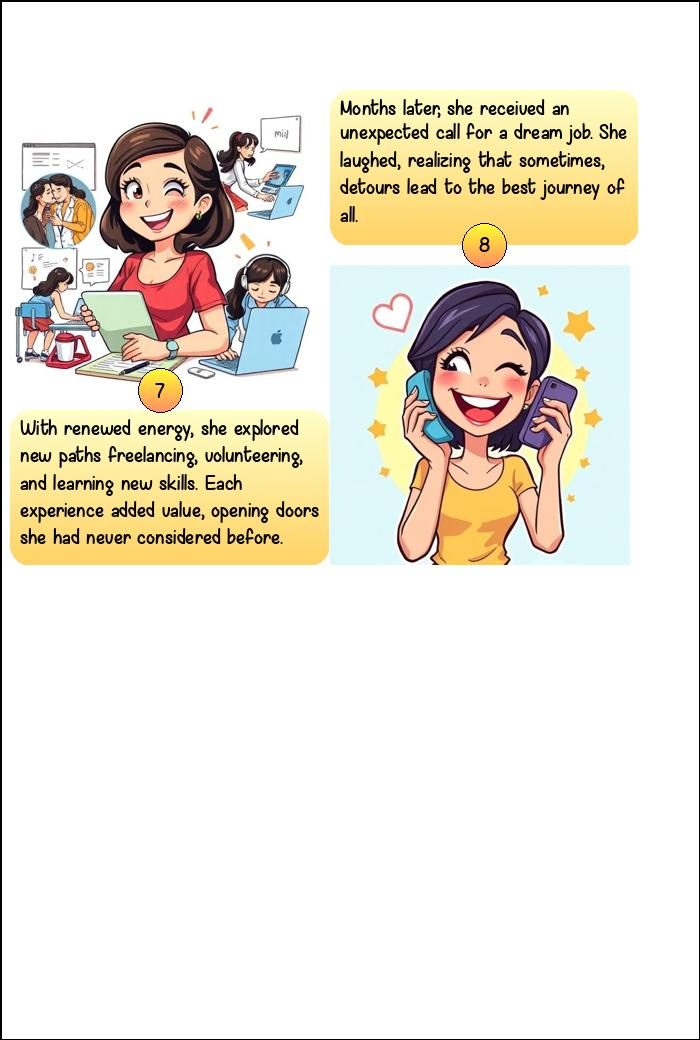

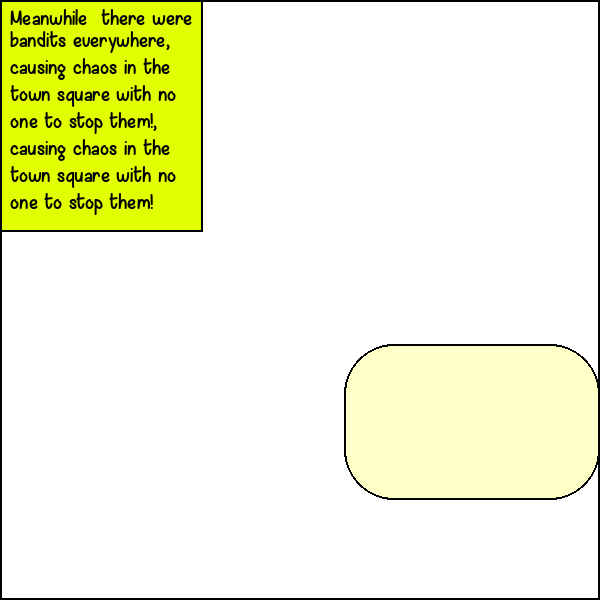

In [280]:
text = "Meanwhile… there were bandits everywhere, causing chaos in the town square with no one to stop them!, causing chaos in the town square with no one to stop them!"
page = create_page(600, 600, color="lightblue")
draw_block(page, (0, 0, 599, 599), fill=(255,255,255, 0), outline_width=2)
x,y,_ = estimate_text_box(text, font_path="/Users/ijazulhaq/Downloads/strawberry-muffins/Strawberry Muffins Demo.ttf", font_size=20,
                      max_width=200, padding=10, line_spacing=5)
draw_block(page, (0, 0, x, y), fill=(225,255,0, 255), outline_width=2)

page = place_wrapped_text(
    page,
    text,
    (0, 0, x, y),
    font_path="/Users/ijazulhaq/Downloads/strawberry-muffins/Strawberry Muffins Demo.ttf",
    font_size=20,
    fill="black",
    outline="white",
    outline_width=0,
    line_spacing=5,
    padding=10
)
page

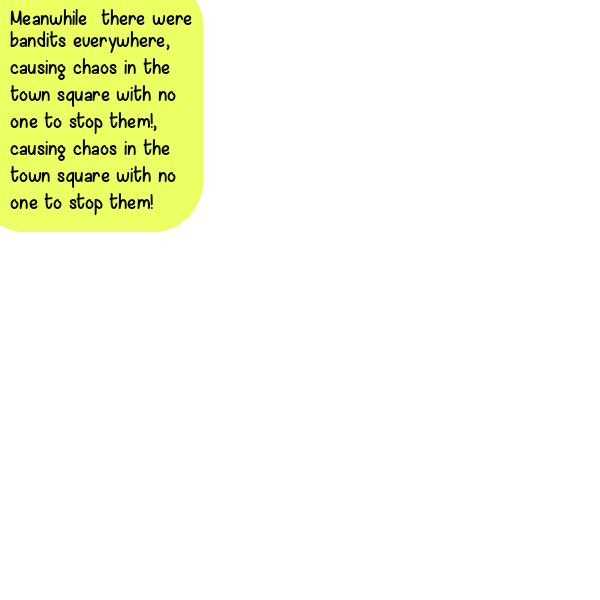

In [302]:
text = "Meanwhile… there were bandits everywhere, causing chaos in the town square with no one to stop them!, causing chaos in the town square with no one to stop them!"
page = create_page(600, 600, color=(225,255,255, 0))
#draw_block(page, (0, 0, 599, 599), fill=(255,255,255, 0), outline_width=2)
x,y,_ = estimate_text_box(text, font_path="/Users/ijazulhaq/Downloads/strawberry-muffins/Strawberry Muffins Demo.ttf", font_size=20,
                      max_width=200, padding=10, line_spacing=5)
draw_rounded_block(page, (-25, -25, x, y), radius=50, fill=(225,255,0, 155), outline="black", outline_width=0)

page = place_wrapped_text(
    page,
    text,
    (0, 0, x, y),
    font_path="/Users/ijazulhaq/Downloads/strawberry-muffins/Strawberry Muffins Demo.ttf",
    font_size=20,
    fill="black",
    outline="white",
    outline_width=0,
    line_spacing=5,
    padding=10
)
page

In [367]:
a,b,x,y = -25, -25, x, y

b = b+100
y = 

-25

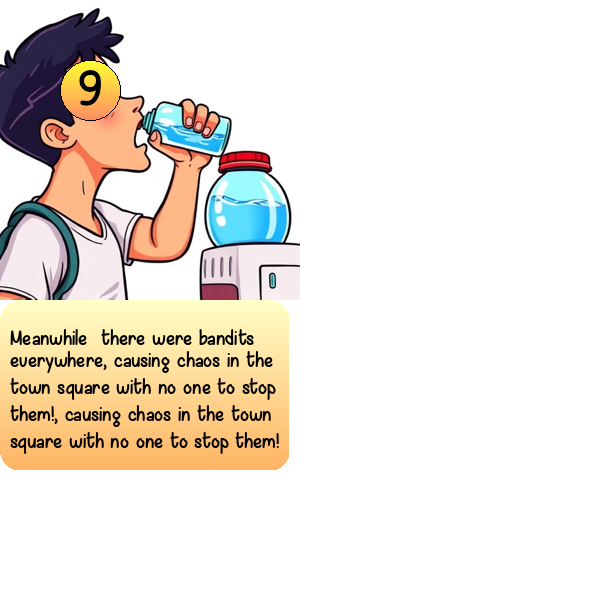

In [462]:

text = "Meanwhile… there were bandits everywhere, causing chaos in the town square with no one to stop them!, causing chaos in the town square with no one to stop them!"
page = create_page(600, 600, color=(225,255,255, 0))
#draw_block(page, (10, 0, 599, 599), fill=(255,255,255, 0), outline_width=2)
x,y,_ = estimate_text_box(text, font_path="/Users/ijazulhaq/Downloads/strawberry-muffins/Strawberry Muffins Demo.ttf", font_size=20,
                      max_width=310, padding=10, line_spacing=5)
a,b,x,y = -25, -25, x, y
draw_gradient_rounded_block(
    page, (0, 0+320-20, x, y+320),
    radius=20,
    top_color=(255,255,200),
    bottom_color=(255,180,100),
    outline="black",
    outline_width=0
)
page = place_wrapped_text(
    page,
    text,
    (0, 0+320, x, y+320),
    font_path="/Users/ijazulhaq/Downloads/strawberry-muffins/Strawberry Muffins Demo.ttf",
    font_size=20,
    fill="black",
    outline="white",
    outline_width=0,
    line_spacing=5,
    padding=10
)
page

img = Image.open('/Users/ijazulhaq/Downloads/_25R4llhv5JCPwL04rqaj.jpeg')

place_image(page, img, ( 0, 0), size=(300,300))


draw_gradient_rounded_block(
    page, (60, 60, 120, 120),
    radius=1300,
    top_color=(255,255,50),
    bottom_color=(255,140,100),
    outline="black",
    outline_width=1
)
place_text(page, '9', (68, 60), font_path="/Users/ijazulhaq/Downloads/strawberry-muffins/Strawberry Muffins Demo.ttf", font_size=48,
               fill="black", outline="black", outline_width=0, padding=10)

In [606]:
texts[1]

'As he swings closer, Spider-Man remembers the last time he faced Hulk. The sheer force and size terrified him. He wonders, "What if he gets mad at me?"'

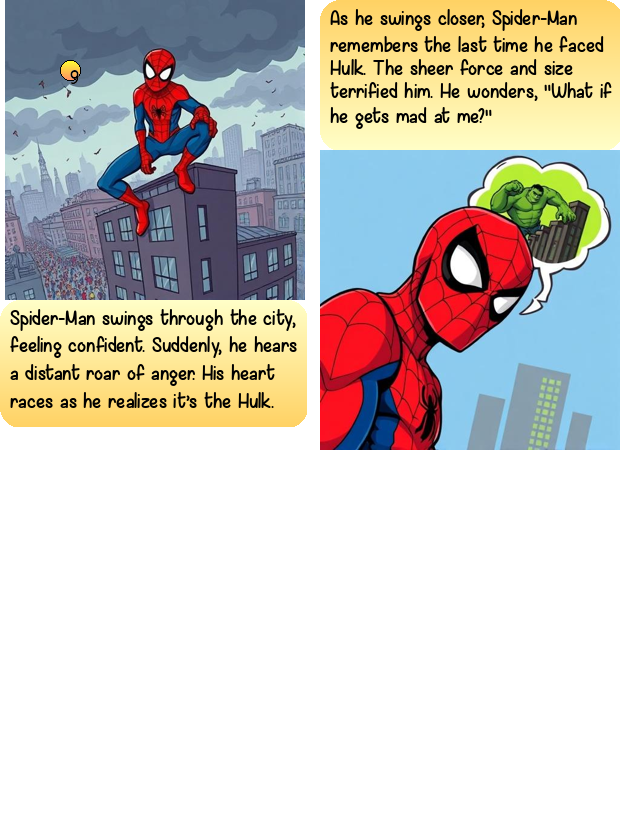

In [650]:
occupied = []

f_path = "/Users/ijazulhaq/Downloads/strawberry-muffins/Strawberry Muffins Demo.ttf"

text1 = texts[0]
text2 = texts[1]
page = create_page(620, 820, color=(225,255,255, 0))

page, rect1 = block_and_text(text1, page, 0, 300, 300)
img = Image.open('image_0.jpg')
page,_ = place_image(page, img, ( 5, 0), size=(300,300))


page, rect2 = text_and_block(text2, page, 320, 0, 300)
img = Image.open('image_1.jpg')
page,_ = place_image(page, img, (620-300, box_h), size=(300,300))
page

draw_gradient_rounded_block(page, (60, 60, 80, 80),radius=1300,top_color=(255,255,50),bottom_color=(255,140,100),outline="black",outline_width=1)
place_text(page, '9', (60, 60), font_path=f_path, font_size=18,fill="black", outline="black", outline_width=0, padding=10)





In [1364]:
import pandas as pd

In [1368]:
df = pd.DataFrame({'employId':['a','b','c','d','e'],'manId':[23,23,45,67,67]})
df

,employId,manId
0,a,23
1,b,23
2,c,45
3,d,67
4,e,67


In [1367]:
df.groupby('salary').count()#.agg({'empplyName'})

,employName
salary,
23,2
45,1
67,2


In [1376]:
a = [1,2,3,4]

def fun(list_):
    l=[]
    for i in a:
        l.append(i*2)
    return l
    
fun(a)

[2, 4, 6, 8]

In [1378]:
a=['apple', 'banana', 'apricot']


[i for i in a if i[0]=='a']

['apple', 'apricot']

In [1396]:
a=['a', 'b', 'b', 'c', 'd', 'd', 'e']

# l=[]
# dup=[]
# for i in a:
#     if i not in l:
#         l.append(i)
#     else:
#         dup.append(i)
        
dic={}
for i in a:
    dic[i]=0
    
    
for i in a:
    dic[i]+=1

dic
    


{'a': 1, 'b': 2, 'c': 1, 'd': 2, 'e': 1}

In [1421]:
a='hello'
inter = a[2]

a.replace('l', 'f', 1)

'heflo'

In [1412]:
a

'hello'

In [1413]:
l = list(a)
for i in l:
    print(i)

h
e
l
l
o


In [1402]:
a='hello'
a.replace('l', 'f', )

'heffo'